<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/multi_stock_anomaly_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================
# 🚀 Standardized Environment Setup
# ==============================

# ✅ Uninstall conflicting packages (one-time cleanup)
!pip uninstall -y protobuf tensorflow gym keras torch torchvision torchaudio || true

# ✅ Install Core ML & RL Libraries (pinned versions)
!pip install protobuf==3.20.3 tensorflow==2.18.0 stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib matplotlib pandas numpy scipy scikit-learn imblearn

# ✅ Install PyTorch with CUDA 12.4 support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# ✅ RAPIDS GPU Acceleration (CUDA 12 compatible)
!pip install --upgrade --force-reinstall \
    dask==2024.11.2 \
    rapids-dask-dependency==24.12.0 \
    cudf-cu12==24.12.0 \
    cuml-cu12==24.12.0 \
    pylibraft-cu12==24.12.0 \
    pylibcudf-cu12==24.12.0 \
    numba==0.61.0


Found existing installation: protobuf 5.29.4
Uninstalling protobuf-5.29.4:
  Successfully uninstalled protobuf-5.29.4
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.

Looking in indexes: https://download.pytorch.org/whl/cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━

In [1]:
# ✅ Set CUDA Paths (clearly once)
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.4'
os.environ['PATH'] += ':/usr/local/cuda-12.4/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-12.4/lib64'

# ✅ Verify GPU Availability and Library Versions
import torch, tensorflow as tf, cudf, cuml, dask, gymnasium, stable_baselines3
print("\n🖥️ GPU & Library Versions")
print("-------------------------")
print(f"✅ PyTorch Version: {torch.__version__}, GPU: {torch.cuda.is_available()}")
print(f"✅ TensorFlow Version: {tf.__version__}, GPU: {tf.config.list_physical_devices('GPU')}")
print(f"✅ cuDF Version: {cudf.__version__}")
print(f"✅ cuML Version: {cuml.__version__}")
print(f"✅ Dask Version: {dask.__version__}")
print(f"✅ Gymnasium Version: {gymnasium.__version__}")
print(f"✅ Stable Baselines3 Version: {stable_baselines3.__version__}")

# ✅ Final GPU Check
!nvidia-smi



🖥️ GPU & Library Versions
-------------------------
✅ PyTorch Version: 2.6.0+cu124, GPU: True
✅ TensorFlow Version: 2.18.0, GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ cuDF Version: 24.12.00
✅ cuML Version: 24.12.00
✅ Dask Version: 2024.11.2
✅ Gymnasium Version: 1.1.1
✅ Stable Baselines3 Version: 2.6.0
Thu Apr  3 02:04:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+=============

In [55]:
# ==============================================
# 🤖 Unified Multi-Stock Anomaly Detection Pipeline
# ==============================================

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from cuml.cluster import DBSCAN, KMeans as cuKMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# ========================
# ✅ Core Functions
# ========================
def load_stock_data(ticker="TSLA", period="720d", interval="1h"):
    print(f"\n📱 Downloading {ticker} stock data...")
    df = yf.download(ticker, period=period, interval=interval)
    if not df.empty:
        print("✅ Downloaded successfully.")
        df.reset_index(inplace=True)
        return df
    else:
        raise ValueError(f"❌ Failed to download data for {ticker}.")

def fix_dataframe_index(df):
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df.loc[:, ~df.columns.duplicated()]

def compute_technical_indicators(df):
    df = df.copy()
    df = fix_dataframe_index(df)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / (loss + 1e-6)
    df['RSI'] = 100 - (100 / (1 + rs))
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df.dropna(inplace=True)
    return df

def run_isolation_forest(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = df[['RSI', 'MACD', 'OBV']]
    clf = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
    df['anomaly_iforest'] = clf.fit_predict(X)
    return df

def run_one_class_svm(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])
    svm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
    df['anomaly_ocsvm'] = svm.fit_predict(X)
    return df

def run_dimensionality_reduction(df, method='t-SNE'):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, max_iter=300)
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2)
    else:
        raise ValueError("Invalid method")
    reduced = reducer.fit_transform(X)
    df['dim1'], df['dim2'] = reduced[:, 0], reduced[:, 1]
    return df

# ========================
# 🤖 PyTorch Autoencoder
# ========================
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

def run_autoencoder(df):
    df = df.dropna(subset=['RSI', 'MACD', 'OBV']).copy()
    X = StandardScaler().fit_transform(df[['RSI', 'MACD', 'OBV']])
    X_tensor = torch.tensor(X, dtype=torch.float32)
    model = Autoencoder(X_tensor.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(30):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, X_tensor)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        reconstructions = model(X_tensor)
        mse = torch.mean((X_tensor - reconstructions) ** 2, dim=1).numpy()
        df['anomaly_autoencoder'] = (mse > np.percentile(mse, 95)).astype(int)
    return df

# ========================
# 🚀 Batch for Multiple Stocks
# ========================
tickers = ["TSLA", "AAPL", "MSFT"]
for ticker in tickers:
    print(f"\n🔁 Processing {ticker}...")
    df = load_stock_data(ticker)
    df = compute_technical_indicators(df)
    df = run_isolation_forest(df)
    df = run_one_class_svm(df)
    df = run_dimensionality_reduction(df)
    df = run_autoencoder(df)


🔁 Processing TSLA...

📱 Downloading TSLA stock data...


[*********************100%***********************]  1 of 1 completed


✅ Downloaded successfully.

🔁 Processing AAPL...

📱 Downloading AAPL stock data...


[*********************100%***********************]  1 of 1 completed


✅ Downloaded successfully.

🔁 Processing MSFT...

📱 Downloading MSFT stock data...


[*********************100%***********************]  1 of 1 completed


✅ Downloaded successfully.


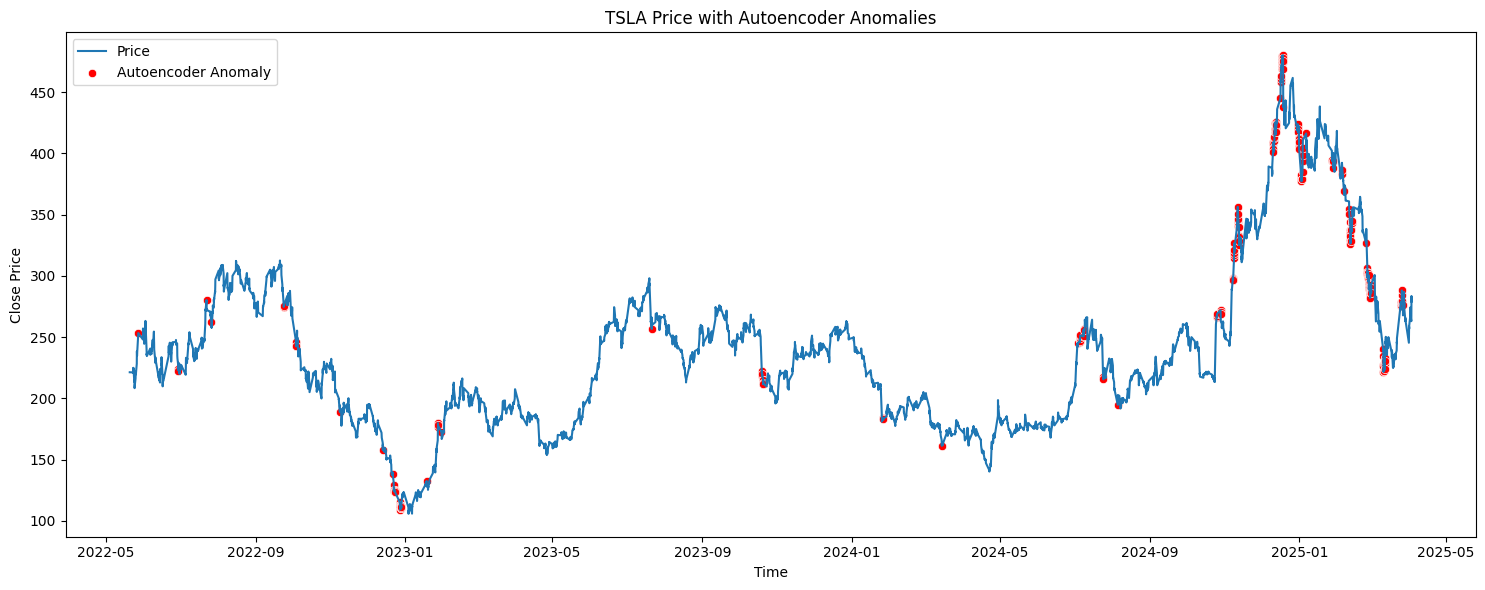

📊 Anomaly Counts for TSLA:
 {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4505}
🔍 Overlap (Autoencoder & IForest): 200
🔍 Overlap (Autoencoder & OCSVM): 103
✅ Completed TSLA.
--------------------------------------------------


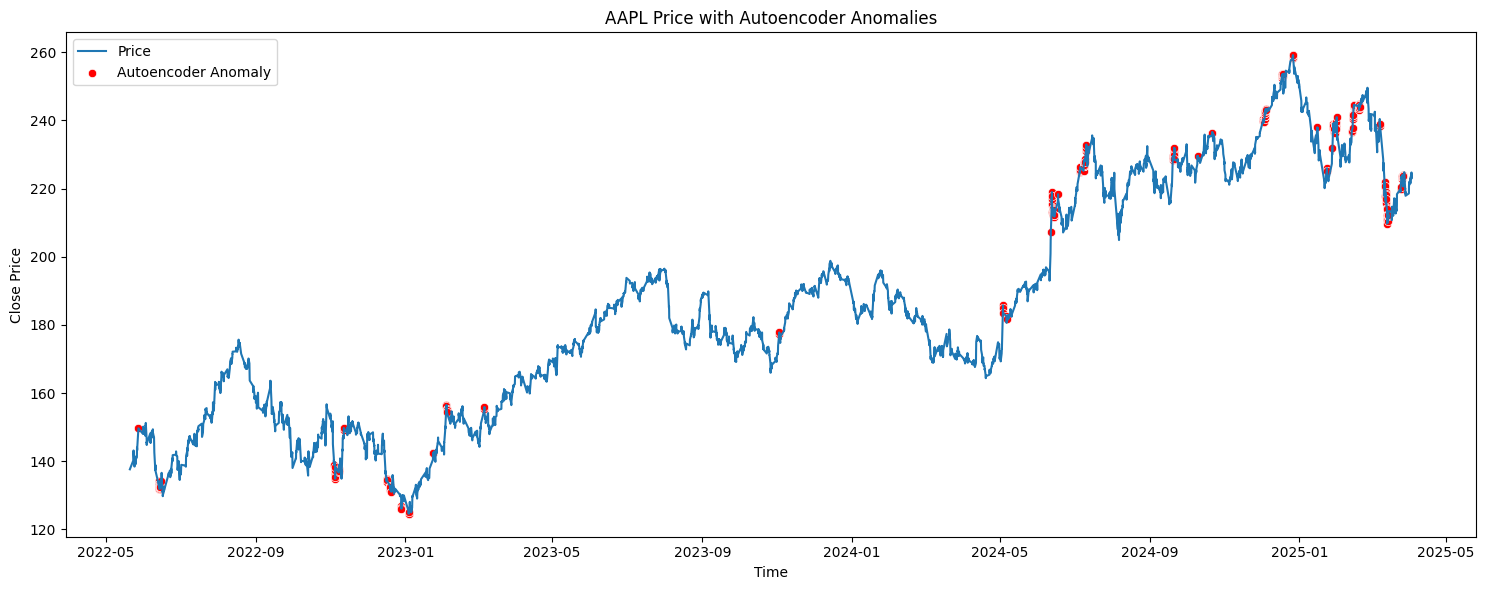

📊 Anomaly Counts for AAPL:
 {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4501}
🔍 Overlap (Autoencoder & IForest): 213
🔍 Overlap (Autoencoder & OCSVM): 110
✅ Completed AAPL.
--------------------------------------------------


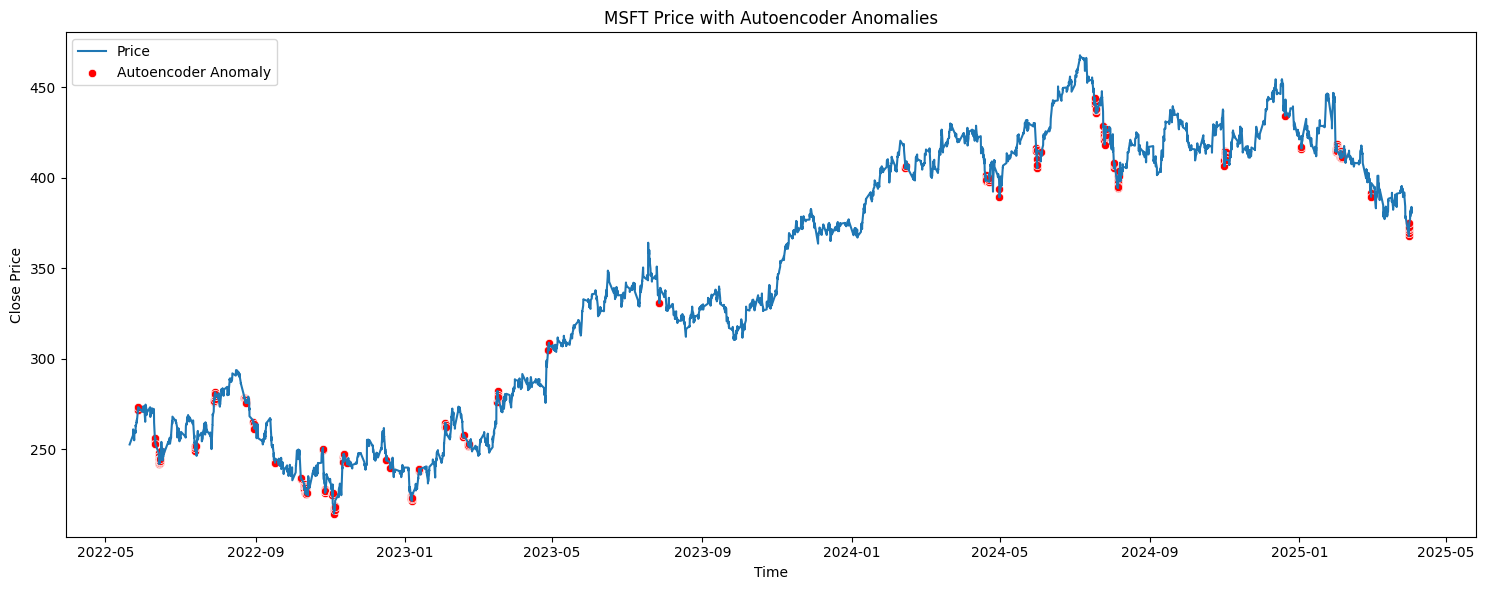

📊 Anomaly Counts for MSFT:
 {'Autoencoder': 251, 'IForest': 4901, 'OCSVM': 4503}
🔍 Overlap (Autoencoder & IForest): 205
🔍 Overlap (Autoencoder & OCSVM): 132
✅ Completed MSFT.
--------------------------------------------------


In [56]:
tickers = ["TSLA", "AAPL", "MSFT"]

def compare_anomaly_methods(df, ticker):
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df, x='Datetime', y='Close', label='Price')
    for method, color in zip(['anomaly_autoencoder', 'anomaly_iforest', 'anomaly_ocsvm'],
                              ['red', 'orange', 'purple']):
        sns.scatterplot(
            data=df[df[method] == 1],
            x='Datetime', y='Close',
            label=method.replace("anomaly_", "").upper(),
            s=40, marker='o', color=color
        )
    plt.title(f'{ticker} Price with Multiple Anomaly Detection Methods')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{ticker.lower()}_compare_anomalies.png")
    plt.close()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Display plots for the previously saved anomaly feature files
tickers = ["TSLA", "AAPL", "MSFT"]

for ticker in tickers:
    try:
        file_path = f"{ticker.lower()}_anomaly_features.csv"
        df = pd.read_csv(file_path, parse_dates=["Datetime"])

        # Plotting the anomalies
        plt.figure(figsize=(15, 6))
        sns.lineplot(x='Datetime', y='Close', data=df, label='Price')
        sns.scatterplot(
            data=df[df['anomaly_autoencoder'] == 1],
            x='Datetime', y='Close',
            color='red', label='Autoencoder Anomaly')
        plt.title(f'{ticker} Price with Autoencoder Anomalies')
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.legend()
        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File not found for {ticker}: {file_path}")


    # ✅ Signal logic
    df['signal'] = 0
    df.loc[df['anomaly_autoencoder'] == 1, 'signal'] = -1
    df.loc[(df['RSI'] < 30) & (df['anomaly_autoencoder'] == 0), 'signal'] = 1

    # ✅ Save data
    df.to_csv(f"{ticker.lower()}_anomaly_features.csv", index=False)
    df[df['anomaly_autoencoder'] == 1][['Datetime', 'Close']].to_csv(f"autoencoder_anomalies_{ticker.lower()}.csv", index=False)

    # ✅ Anomaly counts
    anomaly_counts = {
        "Autoencoder": int(df['anomaly_autoencoder'].sum()),
        "IForest": int(df['anomaly_iforest'].sum()),
        "OCSVM": int(df['anomaly_ocsvm'].sum())
    }
    print(f"📊 Anomaly Counts for {ticker}:\n", anomaly_counts)

    with open(f"anomaly_counts_{ticker.lower()}.json", 'w') as f:
        json.dump(anomaly_counts, f, indent=2)

    # ✅ Overlap logic
    df['overlap_auto_iforest'] = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_iforest'] == 1)).astype(int)
    df['overlap_auto_ocsvm'] = ((df['anomaly_autoencoder'] == 1) & (df['anomaly_ocsvm'] == 1)).astype(int)

    print(f"🔍 Overlap (Autoencoder & IForest): {df['overlap_auto_iforest'].sum()}")
    print(f"🔍 Overlap (Autoencoder & OCSVM): {df['overlap_auto_ocsvm'].sum()}")

    # ✅ Plots
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='Datetime', y='Close', data=df, label='Price')
    sns.scatterplot(data=df[df['anomaly_autoencoder'] == 1], x='Datetime', y='Close',
                    color='red', label='Autoencoder Anomaly')
    plt.title(f'{ticker} Price with Autoencoder Anomalies')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{ticker.lower()}_anomaly_plot.png")
    plt.close()

    # ✅ Multi-method comparison plot
    compare_anomaly_methods(df, ticker)

    print(f"✅ Completed {ticker}.\n{'-'*50}")
